In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
sns.set(style="darkgrid")


from sklearn.model_selection import train_test_split  #数据集的分割函数
from sklearn.preprocessing import StandardScaler      #数据预处理
from sklearn import metrics
from sklearn.utils import shuffle


from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
def rmse(y_true,y_pred):
    return mean_squared_error(y_true=y_true,y_pred=y_pred) ** 0.5

In [2]:
# train1 = pd.read_csv('./data/复赛/保定2016年.csv',encoding = 'gb2312')
train = pd.read_csv('./data/复赛/train.csv')
test  = pd.read_csv('./data/复赛/test.csv')

# train = pd.concat([train1,train2]).reset_index(drop=True)

In [3]:
# 分析数据 发现该数据更适合先用回归模型
data = pd.concat([train,test]).reset_index(drop=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701 entries, 0 to 700
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    701 non-null    object 
 1   AQI     490 non-null    float64
 2   IPRC    490 non-null    float64
 3   PM2_5   701 non-null    float64
 4   PM10    701 non-null    float64
 5   SO2     701 non-null    float64
 6   NO2     701 non-null    float64
 7   CO      701 non-null    float64
 8   O3      701 non-null    float64
dtypes: float64(8), object(1)
memory usage: 49.4+ KB


In [4]:
data.describe()

,AQI,IPRC,PM2_5,PM10,SO2,NO2,CO,O3
count,490.000000,490.000000,701.000000,701.000000,701.000000,701.000000,701.000000,701.000000
mean,87.153061,0.555682,61.406830,130.262066,24.513433,45.974263,1.714339,41.497652
std,37.703545,0.264510,40.648791,70.772481,17.389398,15.604374,0.727702,25.037378
min,20.000000,0.173101,11.000000,18.583333,3.000000,14.000000,0.590833,6.395833
25%,65.000000,0.404471,35.416667,81.416667,12.541667,34.333333,1.193958,20.375000
50%,77.000000,0.481091,49.416667,111.416667,18.916667,43.979167,1.528958,35.333333
75%,99.000000,0.595395,73.812500,158.812500,32.041667,55.291667,2.017917,59.041667
max,254.000000,1.762622,277.708333,441.541667,141.333333,98.958333,5.351250,115.125000


In [5]:
data.corr()

,AQI,IPRC,PM2_5,PM10,SO2,NO2,CO,O3
AQI,1.000000,0.982200,0.940951,0.976399,0.645464,0.628825,0.676860,-0.325561
IPRC,0.982200,1.000000,0.961824,0.958415,0.703346,0.677610,0.737358,-0.358652
PM2_5,0.940951,0.961824,1.000000,0.915142,0.662268,0.673468,0.799783,-0.368722
PM10,0.976399,0.958415,0.915142,1.000000,0.634369,0.707418,0.738838,-0.337589
SO2,0.645464,0.703346,0.662268,0.634369,1.000000,0.573664,0.771526,-0.583944
NO2,0.628825,0.677610,0.673468,0.707418,0.573664,1.000000,0.620340,-0.365185
CO,0.676860,0.737358,0.799783,0.738838,0.771526,0.620340,1.000000,-0.583191
O3,-0.325561,-0.358652,-0.368722,-0.337589,-0.583944,-0.365185,-0.583191,1.000000


(8.5, -0.5)

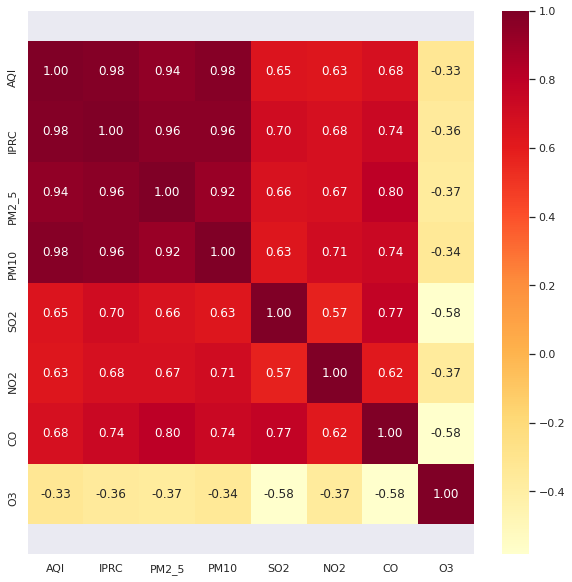

In [6]:
plt.figure(figsize=(10,10))
ax = sns.heatmap(data.corr(),cmap=plt.cm.YlOrRd,annot=True,fmt='.2f')
a,b = ax.get_ylim()
ax.set_ylim(a+0.5,b-0.5)

In [7]:
data['PM2_5'] = data['PM2_5'].apply(lambda x: np.rint(x))
data['PM10'] = data['PM10'].apply(lambda x: np.rint(x))
data['SO2'] = data['SO2'].apply(lambda x: np.rint(x))
data['NO2'] = data['NO2'].apply(lambda x: np.rint(x))
data['CO'] = data['CO'].apply(lambda x: round(x,1))
data['O3'] = data['O3'].apply(lambda x: np.rint(x))

In [8]:
# data['PM2_5'] = data['PM2_5'].apply(lambda x: round(x,1))
# data['PM10'] = data['PM10'].apply(lambda x: round(x,1))
# data['SO2'] = data['SO2'].apply(lambda x: round(x,1))
# data['NO2'] = data['NO2'].apply(lambda x: round(x,1))
# data['CO'] = data['CO'].apply(lambda x: round(x,1))
# data['O3'] = data['O3'].apply(lambda x: round(x,1))

In [9]:
# # 两种四舍五入取整的方法
# from decimal import Decimal
# # Decimal('0.5').quantize(Decimal('1.'))
# Decimal('0.512').quantize(Decimal("1."), rounding = "ROUND_HALF_UP")
# np.rint(1.511)

1.7437906294854835


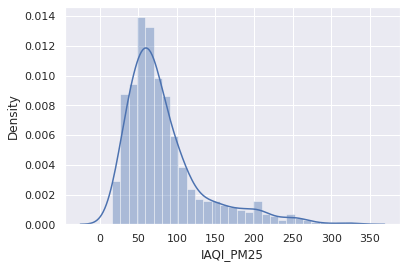

In [10]:
# 对PM2.5区段进行划分 参考河北进行修改 跟国家标准一致
def IAQI_PM25(x):  
    if x >=0 and x<=35:
        y = 50/35 * x
        return y
    elif x>35 and x<=75:
        y = 50/40 * (x-35) + 50
        return y 
    elif x>75 and x<=115:
        y = 50/40 * (x-75) + 100
        return y
    elif x>115 and x<=150:
        y = 50/35 * (x-115) + 150
        return y
    elif x>150 and x<=250:
        y = 100/100 * (x-150) + 200
        return y 
    elif x>250 and x<=350:
        y = 100/100 * (x-250) + 300
        return y
    elif x>350 and x<=500:
        y = 100/150 * (x-350) + 400
        return y 
    else:  
        return 500
    
data['IAQI_PM25'] = data['PM2_5'].apply(lambda x: np.rint(IAQI_PM25(x)))
#核密度分布图
sns.distplot(data["IAQI_PM25"])
print(data["IAQI_PM25"].skew())

1.7452042257535842


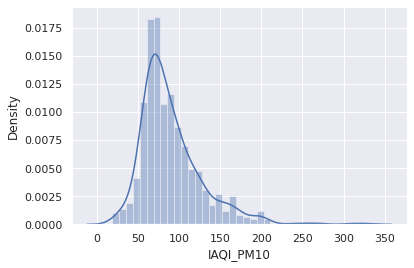

In [11]:
# 对PM10区段进行划分 中国标准
def IAQI_PM10(x):  
    if x >=0 and x<=50:
        y = 50/50 * x
        return y
    elif x>50 and x<=150:
        y = 50/100 * (x-50) + 50
        return y 
    elif x>150 and x<=250:
        y = 50/100 * (x-150) + 100
        return y
    elif x>250 and x<=350:
        y = 50/100 * (x-250) + 150
        return y
    elif x>350 and x<=420:
        y = 100/70 * (x-350) + 200
        return y 
    elif x>420 and x<=500:
        y = 100/80 * (x-420) + 300
        return y
    elif x>500 and x<=600:
        y = 100/100 * (x-500) + 400
        return y 
    else:  
        return 500
    
data['IAQI_PM10'] = data['PM10'].apply(lambda x: np.rint(IAQI_PM10(x)))
#核密度分布图
sns.distplot(data["IAQI_PM10"])
print(data["IAQI_PM10"].skew())

1.1294444816834637


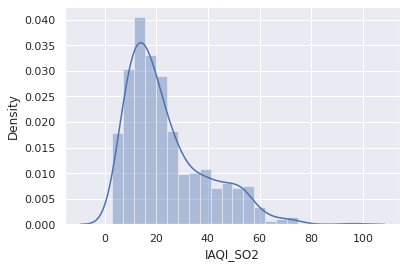

In [12]:
# 中国标准
def IAQI_SO2(x):  
    if x >=0 and x<=50:
        y = 50/50 * x
        return y
    elif x>50 and x<=150:
        y = 50/100 * (x-50) + 50
        return y 
    elif x>150 and x<=475:
        y = 50/325 * (x-150) + 100
        return y
    elif x>475 and x<=800:
        y = 50/325 * (x-475) + 150
        return y
    elif x>800 and x<=1600:
        y = 100/800 * (x-800) + 200
        return y 
    elif x>1600 and x<=2100:
        y = 100/500 * (x-1600) + 300
        return y
    elif x>2100 and x<=2620:
        y = 100/520 * (x-2100) + 400
        return y 
    else:  
        return 500
    
data['IAQI_SO2'] = data['SO2'].apply(lambda x: np.rint(IAQI_SO2(x)))
#核密度分布图
sns.distplot(data["IAQI_SO2"])
print(data["IAQI_SO2"].skew())

0.5262935884143751


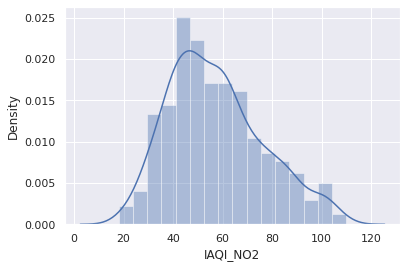

In [13]:
# 中国标准
def IAQI_NO2(x):  
    if x >=0 and x<=40:
        y = 50/40 * x
        return y
    elif x>40 and x<=80:
        y = 50/40 * (x-40) + 50
        return y 
    elif x>80 and x<=180:
        y = 50/100 * (x-80) + 100
        return y
    elif x>180 and x<=280:
        y = 50/100 * (x-180) + 150
        return y
    elif x>280 and x<=565:
        y = 100/285 * (x-280) + 200
        return y 
    elif x>565 and x<=750:
        y = 100/185 * (x-565) + 300
        return y
    elif x>750 and x<=940:
        y = 100/190 * (x-750) + 400
        return y 
    else:  
        return 500
    
data['IAQI_NO2'] = data['NO2'].apply(lambda x: np.rint(IAQI_NO2(x)))
#核密度分布图
sns.distplot(data["IAQI_NO2"])
print(data["IAQI_NO2"].skew())

In [14]:
# # 参考河北标准修改
# def IAQI_NO2(x):  
#     if x >=0 and x<=100:
#         y = 50/100 * x
#         return y
#     elif x>100 and x<=200:
#         y = 50/100 * (x-100) + 50
#         return y 
#     elif x>200 and x<=600:
#         y = 100/400 * (x-200) + 100
#         return y

    
# data['IAQI_NO2'] = data['NO2'].apply(lambda x: np.rint(IAQI_NO2(x)))
# #核密度分布图
# sns.distplot(data["IAQI_NO2"])
# print(data["IAQI_NO2"].skew())

1.3676317364264658


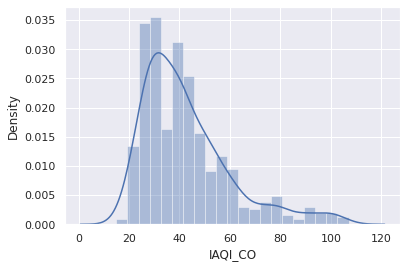

In [15]:
# 中国标准
def IAQI_CO(x):  
    if x >=0 and x<=2:
        y = 50/2 * x
        return y
    elif x>2 and x<=4:
        y = 50/2 * (x-2) + 50
        return y  
    else:
        y = 50/10 * (x-4) + 100
        return y
    
data['IAQI_CO'] = data['CO'].apply(lambda x: np.rint(IAQI_CO(x)))
#核密度分布图
sns.distplot(data["IAQI_CO"])
print(data["IAQI_CO"].skew())

In [16]:
# # 美国标准
# def IAQI_CO(x):  
#     if x >=0 and x<=5:
#         y = 50/5 * x
#         return y
#     elif x>5 and x<=10:
#         y = 50/5 * (x-5) + 50
#         return y  
#     else:
#         y = 50/5 * (x-10) + 100
#         return y
    
# data['IAQI_CO'] = data['CO'].apply(lambda x: np.rint(IAQI_CO(x)))
# #核密度分布图
# sns.distplot(data["IAQI_CO"])
# print(data["IAQI_CO"].skew())

0.7076292144143042


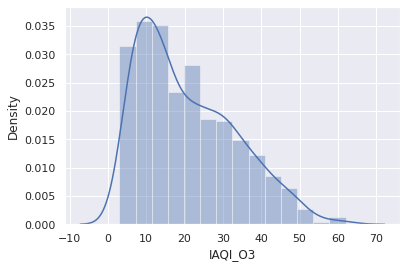

In [17]:
# 中国标准
def IAQI_O3(x):  
    if x >=0 and x<=100:
        y = 50/100 * x
        return y
    elif x>100 and x<=160:
        y = 50/60 * (x-100) + 50
        return y 
    elif x>160 and x<=215:
        y = 50/55 * (x-160) + 100
        return y
    elif x>215 and x<=265:
        y = 50/50 * (x-215) + 150
        return y
    else: 
        y = 100/535 * (x-265) + 200
        return y
    
    
data['IAQI_O3'] = data['O3'].apply(lambda x: np.rint(IAQI_O3(x)))
#核密度分布图
sns.distplot(data["IAQI_O3"])
print(data["IAQI_O3"].skew())

In [18]:
# # 美国标准
# def IAQI_O3(x):  
#     if x >=0 and x<=120:
#         y = 50/120 * x
#         return y
#     elif x>120 and x<=150:
#         y = 50/30 * (x-120) + 50
#         return y 
#     elif x>150 and x<=190:
#         y = 50/40 * (x-150) + 100
#         return y
#     elif x>190 and x<=230:
#         y = 50/40 * (x-190) + 150
#         return y
#     else: 
#         y = 100/500 * (x-230) + 200
#         return y
    
    
# data['IAQI_O3'] = data['O3'].apply(lambda x: np.rint(IAQI_O3(x)))
# #核密度分布图
# sns.distplot(data["IAQI_O3"])
# print(data["IAQI_O3"].skew())

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701 entries, 0 to 700
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       701 non-null    object 
 1   AQI        490 non-null    float64
 2   IPRC       490 non-null    float64
 3   PM2_5      701 non-null    float64
 4   PM10       701 non-null    float64
 5   SO2        701 non-null    float64
 6   NO2        701 non-null    float64
 7   CO         701 non-null    float64
 8   O3         701 non-null    float64
 9   IAQI_PM25  701 non-null    float64
 10  IAQI_PM10  701 non-null    float64
 11  IAQI_SO2   701 non-null    float64
 12  IAQI_NO2   701 non-null    float64
 13  IAQI_CO    701 non-null    float64
 14  IAQI_O3    701 non-null    float64
dtypes: float64(14), object(1)
memory usage: 82.3+ KB


#### 首要污染物 计算AQI
存在两种计算主要污染物的方式

1.依据IAQI

2.依据ci/si

In [20]:
temp = data.iloc[:,9:15]
temp.head()

,IAQI_PM25,IAQI_PM10,IAQI_SO2,IAQI_NO2,IAQI_CO,IAQI_O3
0,74.0,76.0,14.0,26.0,42.0,38.0
1,95.0,95.0,13.0,30.0,50.0,42.0
2,79.0,85.0,14.0,21.0,45.0,46.0
3,49.0,58.0,10.0,22.0,42.0,26.0
4,98.0,86.0,13.0,41.0,45.0,30.0


In [21]:
temp = data.iloc[:,9:15]
data['max_idx'] = temp.idxmax(axis=1) #求一行的最大值对应的索引
data['max_val']= temp.max(axis=1)#取出该最大值
data['mean_val']= temp.mean(axis=1)#取出该均值
data['median_val']= temp.median(axis=1)#取出该中位数
data['I_val'] = (data['max_val'] * data['mean_val'])**0.5
data.head()

,date,AQI,IPRC,PM2_5,PM10,SO2,NO2,CO,O3,IAQI_PM25,IAQI_PM10,IAQI_SO2,IAQI_NO2,IAQI_CO,IAQI_O3,max_idx,max_val,mean_val,median_val,I_val
0,2014/6/1,78.0,0.480805,54.0,103.0,14.0,21.0,1.7,75.0,74.0,76.0,14.0,26.0,42.0,38.0,IAQI_PM10,76.0,45.000000,40.0,58.480766
1,2014/6/2,101.0,0.587508,71.0,140.0,13.0,24.0,2.0,83.0,95.0,95.0,13.0,30.0,50.0,42.0,IAQI_PM25,95.0,54.166667,46.0,71.734464
2,2014/6/3,86.0,0.525599,58.0,120.0,14.0,17.0,1.8,91.0,79.0,85.0,14.0,21.0,45.0,46.0,IAQI_PM10,85.0,48.333333,45.5,64.096282
3,2014/6/4,59.0,0.364717,34.0,66.0,10.0,18.0,1.7,51.0,49.0,58.0,10.0,22.0,42.0,26.0,IAQI_PM10,58.0,34.500000,34.0,44.732538
4,2014/6/5,100.0,0.584368,73.0,123.0,13.0,33.0,1.8,61.0,98.0,86.0,13.0,41.0,45.0,30.0,IAQI_PM25,98.0,52.166667,43.0,71.500583


### 排除异常值

In [22]:
data_temp = data[:train.shape[0]]
data_temp['gap'] = abs(data_temp['AQI'] - data_temp['max_val'])
# data_temp['gap'] = data_temp['AQI'] - data_temp['max_val']

In [23]:
data_temp['gap'].describe()

count    490.000000
mean       1.842857
std        3.272523
min        0.000000
25%        0.000000
50%        1.000000
75%        2.000000
max       49.000000
Name: gap, dtype: float64

<AxesSubplot:>

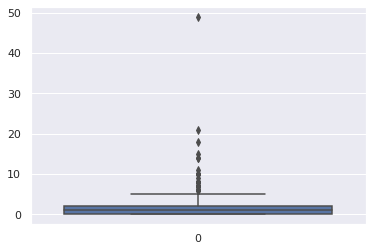

In [24]:
sns.boxplot(data=data_temp['gap'])

四分位距IQR=Q3-Q1，
那么上限=Q3+1.5IQR
下限=Q1-1.5IQR

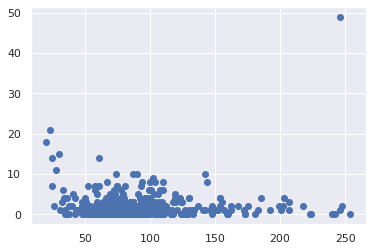

In [25]:
plt.scatter(data_temp['AQI'], data_temp['gap'])
plt.show()

In [26]:
train_temp = data_temp[data_temp['gap']<=10]
del train_temp['gap']
train_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 483 entries, 0 to 489
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        483 non-null    object 
 1   AQI         483 non-null    float64
 2   IPRC        483 non-null    float64
 3   PM2_5       483 non-null    float64
 4   PM10        483 non-null    float64
 5   SO2         483 non-null    float64
 6   NO2         483 non-null    float64
 7   CO          483 non-null    float64
 8   O3          483 non-null    float64
 9   IAQI_PM25   483 non-null    float64
 10  IAQI_PM10   483 non-null    float64
 11  IAQI_SO2    483 non-null    float64
 12  IAQI_NO2    483 non-null    float64
 13  IAQI_CO     483 non-null    float64
 14  IAQI_O3     483 non-null    float64
 15  max_idx     483 non-null    object 
 16  max_val     483 non-null    float64
 17  mean_val    483 non-null    float64
 18  median_val  483 non-null    float64
 19  I_val       483 non-null    f

In [27]:
test_temp = data[train.shape[0]:]
test_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211 entries, 490 to 700
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        211 non-null    object 
 1   AQI         0 non-null      float64
 2   IPRC        0 non-null      float64
 3   PM2_5       211 non-null    float64
 4   PM10        211 non-null    float64
 5   SO2         211 non-null    float64
 6   NO2         211 non-null    float64
 7   CO          211 non-null    float64
 8   O3          211 non-null    float64
 9   IAQI_PM25   211 non-null    float64
 10  IAQI_PM10   211 non-null    float64
 11  IAQI_SO2    211 non-null    float64
 12  IAQI_NO2    211 non-null    float64
 13  IAQI_CO     211 non-null    float64
 14  IAQI_O3     211 non-null    float64
 15  max_idx     211 non-null    object 
 16  max_val     211 non-null    float64
 17  mean_val    211 non-null    float64
 18  median_val  211 non-null    float64
 19  I_val       211 non-null   

In [28]:
data = pd.concat([train_temp,test_temp]).reset_index(drop=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 694 entries, 0 to 693
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        694 non-null    object 
 1   AQI         483 non-null    float64
 2   IPRC        483 non-null    float64
 3   PM2_5       694 non-null    float64
 4   PM10        694 non-null    float64
 5   SO2         694 non-null    float64
 6   NO2         694 non-null    float64
 7   CO          694 non-null    float64
 8   O3          694 non-null    float64
 9   IAQI_PM25   694 non-null    float64
 10  IAQI_PM10   694 non-null    float64
 11  IAQI_SO2    694 non-null    float64
 12  IAQI_NO2    694 non-null    float64
 13  IAQI_CO     694 non-null    float64
 14  IAQI_O3     694 non-null    float64
 15  max_idx     694 non-null    object 
 16  max_val     694 non-null    float64
 17  mean_val    694 non-null    float64
 18  median_val  694 non-null    float64
 19  I_val       694 non-null    f

### 根据质量等级排除异常

In [29]:
data_temp = data[:train.shape[0]]
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490 entries, 0 to 489
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        490 non-null    object 
 1   AQI         489 non-null    float64
 2   IPRC        489 non-null    float64
 3   PM2_5       490 non-null    float64
 4   PM10        490 non-null    float64
 5   SO2         490 non-null    float64
 6   NO2         490 non-null    float64
 7   CO          490 non-null    float64
 8   O3          490 non-null    float64
 9   IAQI_PM25   490 non-null    float64
 10  IAQI_PM10   490 non-null    float64
 11  IAQI_SO2    490 non-null    float64
 12  IAQI_NO2    490 non-null    float64
 13  IAQI_CO     490 non-null    float64
 14  IAQI_O3     490 non-null    float64
 15  max_idx     490 non-null    object 
 16  max_val     490 non-null    float64
 17  mean_val    490 non-null    float64
 18  median_val  490 non-null    float64
 19  I_val       490 non-null    f

In [33]:
def quality_level(x):  
    if x >=0 and x<=50:
        return '优'
    elif x>50 and x<=100:
        return '良' 
    elif x>100 and x<=150:
        return '轻度污染'
    elif x>150 and x<=200:
        return '中度污染'
    elif x>200 and x<=300:
        return '重度污染' 
    elif x>300 and x<=500:
        return '严重污染'
    else:  
        return  '未知'

data_temp['AQI_质量等级'] = data_temp['AQI'].apply(lambda x: quality_level(x))
data_temp['max_val_质量等级'] = data_temp['max_val'].apply(lambda x: quality_level(x))

In [24]:
def function(a, b):
    if a == b:
        return 1
    else:
        return 0
data_temp['bool'] = data_temp.apply(lambda x : function(x['AQI_质量等级'],x['max_val_质量等级']),axis = 1)

In [25]:
train_temp = data_temp[data_temp['bool']==1]
train_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 469 entries, 0 to 489
Data columns (total 23 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          469 non-null    object 
 1   AQI           469 non-null    float64
 2   IPRC          469 non-null    float64
 3   PM2_5         469 non-null    float64
 4   PM10          469 non-null    float64
 5   SO2           469 non-null    float64
 6   NO2           469 non-null    float64
 7   CO            469 non-null    float64
 8   O3            469 non-null    float64
 9   IAQI_PM25     469 non-null    float64
 10  IAQI_PM10     469 non-null    float64
 11  IAQI_SO2      469 non-null    float64
 12  IAQI_NO2      469 non-null    float64
 13  IAQI_CO       469 non-null    float64
 14  IAQI_O3       469 non-null    float64
 15  max_idx       469 non-null    object 
 16  max_val       469 non-null    float64
 17  mean_val      469 non-null    float64
 18  median_val    469 non-null    

In [26]:
del train_temp['AQI_质量等级']
del train_temp['max_val_质量等级']
del train_temp['bool']
train_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 469 entries, 0 to 489
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        469 non-null    object 
 1   AQI         469 non-null    float64
 2   IPRC        469 non-null    float64
 3   PM2_5       469 non-null    float64
 4   PM10        469 non-null    float64
 5   SO2         469 non-null    float64
 6   NO2         469 non-null    float64
 7   CO          469 non-null    float64
 8   O3          469 non-null    float64
 9   IAQI_PM25   469 non-null    float64
 10  IAQI_PM10   469 non-null    float64
 11  IAQI_SO2    469 non-null    float64
 12  IAQI_NO2    469 non-null    float64
 13  IAQI_CO     469 non-null    float64
 14  IAQI_O3     469 non-null    float64
 15  max_idx     469 non-null    object 
 16  max_val     469 non-null    float64
 17  mean_val    469 non-null    float64
 18  median_val  469 non-null    float64
 19  I_val       469 non-null    f

In [27]:
test_temp = data[train.shape[0]:]
test_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211 entries, 490 to 700
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        211 non-null    object 
 1   AQI         0 non-null      float64
 2   IPRC        0 non-null      float64
 3   PM2_5       211 non-null    float64
 4   PM10        211 non-null    float64
 5   SO2         211 non-null    float64
 6   NO2         211 non-null    float64
 7   CO          211 non-null    float64
 8   O3          211 non-null    float64
 9   IAQI_PM25   211 non-null    float64
 10  IAQI_PM10   211 non-null    float64
 11  IAQI_SO2    211 non-null    float64
 12  IAQI_NO2    211 non-null    float64
 13  IAQI_CO     211 non-null    float64
 14  IAQI_O3     211 non-null    float64
 15  max_idx     211 non-null    object 
 16  max_val     211 non-null    float64
 17  mean_val    211 non-null    float64
 18  median_val  211 non-null    float64
 19  I_val       211 non-null   

In [28]:
data = pd.concat([train_temp,test_temp]).reset_index(drop=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 680 entries, 0 to 679
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        680 non-null    object 
 1   AQI         469 non-null    float64
 2   IPRC        469 non-null    float64
 3   PM2_5       680 non-null    float64
 4   PM10        680 non-null    float64
 5   SO2         680 non-null    float64
 6   NO2         680 non-null    float64
 7   CO          680 non-null    float64
 8   O3          680 non-null    float64
 9   IAQI_PM25   680 non-null    float64
 10  IAQI_PM10   680 non-null    float64
 11  IAQI_SO2    680 non-null    float64
 12  IAQI_NO2    680 non-null    float64
 13  IAQI_CO     680 non-null    float64
 14  IAQI_O3     680 non-null    float64
 15  max_idx     680 non-null    object 
 16  max_val     680 non-null    float64
 17  mean_val    680 non-null    float64
 18  median_val  680 non-null    float64
 19  I_val       680 non-null    f

### 特征处理

In [29]:
def quality_level(x):  
    if x >=0 and x<=50:
        return '优'
    elif x>50 and x<=100:
        return '良' 
    elif x>100 and x<=150:
        return '轻度污染'
    elif x>150 and x<=200:
        return '中度污染'
    elif x>200 and x<=300:
        return '重度污染' 
    elif x>300 and x<=500:
        return '严重污染'
    else:  
        return  '未知'

data['max_val_质量等级'] = data['max_val'].apply(lambda x: quality_level(x))

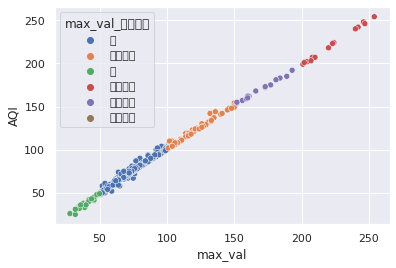

In [30]:
sns.scatterplot(x = "max_val", y = "AQI",data=data, hue='max_val_质量等级')
sns.set(style='whitegrid',)
plt.show()

In [31]:
data.loc[data.max_val<=50,'max_idx'] = 'None_Pollution'

In [32]:
data['max_idx'].unique()

array(['IAQI_PM10', 'IAQI_PM25', 'None_Pollution', 'IAQI_NO2', 'IAQI_CO'],
      dtype=object)

In [33]:
data['max_idx'] = data['max_idx'].replace('IAQI_PM25', 'PM25_P') 
data['max_idx'] = data['max_idx'].replace('IAQI_PM10', 'PM10_P')
data['max_idx'] = data['max_idx'].replace('IAQI_CO', 'CO_P') 
data['max_idx'] = data['max_idx'].replace('IAQI_NO2', 'NO2_P') 
# # data['max_idx'] = data['max_idx'].replace('IAQI_O3', 'O3_P') 
# data['max_idx'] = data['max_idx'].replace('IAQI_SO2', 'SO2_P')

data_onehot = pd.get_dummies(data['max_idx'])

data = pd.concat([data,data_onehot],axis=1)
data.head()

,date,AQI,IPRC,PM2_5,PM10,SO2,NO2,CO,O3,IAQI_PM25,...,max_val,mean_val,median_val,I_val,max_val_质量等级,CO_P,NO2_P,None_Pollution,PM10_P,PM25_P
0,2014/6/1,78.0,0.480805,54.0,103.0,14.0,21.0,1.7,75.0,74.0,...,76.0,45.000000,40.0,58.480766,良,0,0,0,1,0
1,2014/6/2,101.0,0.587508,71.0,140.0,13.0,24.0,2.0,83.0,95.0,...,95.0,54.166667,46.0,71.734464,良,0,0,0,0,1
2,2014/6/3,86.0,0.525599,58.0,120.0,14.0,17.0,1.8,91.0,79.0,...,85.0,48.333333,45.5,64.096282,良,0,0,0,1,0
3,2014/6/4,59.0,0.364717,34.0,66.0,10.0,18.0,1.7,51.0,49.0,...,58.0,34.500000,34.0,44.732538,良,0,0,0,1,0
4,2014/6/5,100.0,0.584368,73.0,123.0,13.0,33.0,1.8,61.0,98.0,...,98.0,52.166667,43.0,71.500583,良,0,0,0,0,1


In [34]:
data_onehot = pd.get_dummies(data['max_val_质量等级'])

data = pd.concat([data,data_onehot],axis=1)
data.head()

,date,AQI,IPRC,PM2_5,PM10,SO2,NO2,CO,O3,IAQI_PM25,...,NO2_P,None_Pollution,PM10_P,PM25_P,严重污染,中度污染,优,良,轻度污染,重度污染
0,2014/6/1,78.0,0.480805,54.0,103.0,14.0,21.0,1.7,75.0,74.0,...,0,0,1,0,0,0,0,1,0,0
1,2014/6/2,101.0,0.587508,71.0,140.0,13.0,24.0,2.0,83.0,95.0,...,0,0,0,1,0,0,0,1,0,0
2,2014/6/3,86.0,0.525599,58.0,120.0,14.0,17.0,1.8,91.0,79.0,...,0,0,1,0,0,0,0,1,0,0
3,2014/6/4,59.0,0.364717,34.0,66.0,10.0,18.0,1.7,51.0,49.0,...,0,0,1,0,0,0,0,1,0,0
4,2014/6/5,100.0,0.584368,73.0,123.0,13.0,33.0,1.8,61.0,98.0,...,0,0,0,1,0,0,0,1,0,0


In [35]:
data['date'] = pd.to_datetime(data['date'],format='%Y-%m-%d')
data['month']=data['date'].dt.month
data['quarter']=data['date'].dt.quarter

#### 是否高于年平均二级浓度限值

In [36]:
data['PM25_year'] =data['PM2_5'].apply(lambda x: 0 if x <=35 else 1)
data['PM10_year'] =data['PM10'].apply(lambda x: 0 if x <=70 else 1)
data['SO2_year'] =data['SO2'].apply(lambda x: 0 if x <=60 else 1)
data['NO2_year'] =data['NO2'].apply(lambda x: 0 if x <=40 else 1)
# data['CO_year'] =data['CO'].apply(lambda x: 0 if x <=4 else 1)
# data['O3_8h_year'] =data['O3_8h'].apply(lambda x: 0 if x <=160 else 1)

#### 是否高于日平均二级浓度限值

In [37]:
data['PM25_day'] =data['PM2_5'].apply(lambda x: 0 if x <=75 else 1)
data['PM10_day'] =data['PM10'].apply(lambda x: 0 if x <=150 else 1)
data['SO2_day'] =data['SO2'].apply(lambda x: 0 if x <=150 else 1)
data['NO2_day'] =data['NO2'].apply(lambda x: 0 if x <=80 else 1)
data['CO_day'] =data['CO'].apply(lambda x: 0 if x <=4 else 1)
data['O3_day'] =data['O3'].apply(lambda x: 0 if x <=160 else 1)

In [38]:
data['SO2_B'] = data['SO2'].apply(lambda x: 0 if x <=150 else (x-150)/150)

data['NO2_B'] = data['NO2'].apply(lambda x: 0 if x <=80 else (x-80)/80)

data['PM10_B'] = data['PM10'].apply(lambda x: 0 if x <=150 else (x-150)/150)

data['PM25_B'] = data['PM2_5'].apply(lambda x: 0 if x <=75 else (x-75)/75)

data['CO_B'] = data['CO'].apply(lambda x: 0 if x <=4 else (x-4)/4)

data['O3_B'] = data['O3'].apply(lambda x: 0 if x <=160 else (x-160)/160)

#### 单项质量指数

当 i 为 SO2、 NO2、 PM10及 PM2.5时，Si为污染物 i 的年均浓度二级标准限值；

当 i 为 O3时， Si为日最大8 小时平均的二级标准限值；当 i 为 CO 时， Si为日均浓度二级标准限值。

In [39]:
data['SO2_index'] = data['SO2'] / 60

data['NO2_index'] = data['NO2'] / 40

data['PM10_index'] = data['PM10'] / 70

data['PM25_index'] = data['PM2_5'] / 35

data['CO_index'] = data['CO'] / 4

data['O3_index'] = data['O3'] / 160

In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 694 entries, 0 to 693
Data columns (total 56 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            694 non-null    datetime64[ns]
 1   AQI             483 non-null    float64       
 2   IPRC            483 non-null    float64       
 3   PM2_5           694 non-null    float64       
 4   PM10            694 non-null    float64       
 5   SO2             694 non-null    float64       
 6   NO2             694 non-null    float64       
 7   CO              694 non-null    float64       
 8   O3              694 non-null    float64       
 9   IAQI_PM25       694 non-null    float64       
 10  IAQI_PM10       694 non-null    float64       
 11  IAQI_SO2        694 non-null    float64       
 12  IAQI_NO2        694 non-null    float64       
 13  IAQI_CO         694 non-null    float64       
 14  IAQI_O3         694 non-null    float64       
 15  max_id

In [41]:
temp = data.iloc[:,50:56]
data['max_index']= temp.max(axis=1)#取出该最大值
data['sum_index']= temp.sum(axis=1)#取出该最大值
data['mean_index']= temp.mean(axis=1)#取出该最大值
data['median_index']= temp.median(axis=1)#取出该最大值
data['I_index'] = (data['max_index'] * data['mean_index'])**0.5
data['zong_index'] = ((data['max_index']**2 + data['mean_index']**2)/2)**0.5

In [42]:
# data['SO2_index1'] = data['SO2'] / 50

# data['NO2_index1'] = data['NO2'] / 80

# data['PM10_index1'] = data['PM10'] / 50

# data['PM25_index1'] = data['PM2_5'] / 35

# data['CO_index1'] = data['CO'] / 4

# data['O3_index1'] = data['O3'] / 160

#### 构造交叉项

In [43]:
data['PM25_PM10'] = data['PM2_5'] * data['PM10']
data['PM25_CO'] = data['PM2_5'] * data['CO']
# data['PM10_CO'] = data['PM10'] * data['CO']
# data['PM10_NO2'] = data['PM10'] * data['NO2']
# data['SO2_CO'] = data['SO2'] * data['CO']

In [44]:
# data['IAQI_PM25_PM10'] = data['IAQI_PM25'] * data['IAQI_PM10']
# data['IAQI_PM25_CO'] = data['IAQI_PM25'] * data['IAQI_CO']
# data['IAQI_PM10_CO'] = data['IAQI_PM10'] * data['IAQI_CO']
# data['IAQI_PM10_NO2'] = data['IAQI_PM10'] * data['IAQI_NO2']
# data['IAQI_SO2_CO'] = data['IAQI_SO2'] * data['IAQI_CO']

In [45]:
# 保留两位小数
index_feature = ['PM25_index', 'PM10_index', 'SO2_index', 'NO2_index', 'CO_index', 'O3_index',
#                  'PM25_index1', 'PM10_index1', 'SO2_index1', 'NO2_index1', 'CO_index1', 'O3_index1',
#                  'PM25_B', 'PM10_B', 'SO2_B', 'NO2_B', 'CO_B', 'O3_B',
#                  'PM25_mean', 'PM10_mean', 'SO2_mean', 'NO2_mean', 'CO_mean', 'O3_mean',
#                  'PM10_CO','SO2_CO','PM10_NO2',
                 'PM25_PM10','PM25_CO',
                 'median_val',
                 'max_index','sum_index','mean_index','median_index','I_index','zong_index']
for f in index_feature:
    data[f] = data[f].apply(lambda x: round(x,2))

### 数据划分为大小两部分

In [46]:
data_low = data[data['max_val']<=150].reset_index()
# data_low = data.loc[(data['quarter']>=1)&(data['quarter']<=2)].reset_index()
data_low.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 612 entries, 0 to 611
Data columns (total 65 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   index           612 non-null    int64         
 1   date            612 non-null    datetime64[ns]
 2   AQI             452 non-null    float64       
 3   IPRC            452 non-null    float64       
 4   PM2_5           612 non-null    float64       
 5   PM10            612 non-null    float64       
 6   SO2             612 non-null    float64       
 7   NO2             612 non-null    float64       
 8   CO              612 non-null    float64       
 9   O3              612 non-null    float64       
 10  IAQI_PM25       612 non-null    float64       
 11  IAQI_PM10       612 non-null    float64       
 12  IAQI_SO2        612 non-null    float64       
 13  IAQI_NO2        612 non-null    float64       
 14  IAQI_CO         612 non-null    float64       
 15  IAQI_O

In [47]:
feature = [
    'PM2_5', 'PM10', 'SO2', 'CO', 'NO2',  'O3',
#     'PM25_mean', 'PM10_mean', 'SO2_mean', 'NO2_mean', 'CO_mean', 'O3_mean',
#     'PM25_PM10','PM25_CO','PM10_CO','SO2_CO','PM10_NO2',
#     'IAQI_PM25_PM10','IAQI_PM25_CO',
#     'IAQI_PM10_CO','IAQI_PM10_NO2','IAQI_SO2_CO',
    'IAQI_PM25', 'IAQI_PM10', 'IAQI_SO2', 'IAQI_CO', 'IAQI_NO2','IAQI_O3',
    'max_val','median_val',
#     'I_val',
#     'PM25_index', 'PM10_index', 'SO2_index', 'NO2_index', 'CO_index', 'O3_index',
#     'PM25_index1', 'PM10_index1', 'SO2_index1', 'NO2_index1', 'CO_index1', 'O3_index1',
    'sum_index','max_index',
    'zong_index',
#     'I_index',
    'median_index',
    'PM25_year', 'PM10_year', 'SO2_year',  'NO2_year',
#     'PM25_day', 'PM10_day',  'NO2_day', 'CO_day', 
#     'O3_day','SO2_day',
#     'PM25_B', 'PM10_B', 
#     'NO2_B', 'CO_B', 
#     'O3_B',
#     'SO2_B', 
    'PM25_P','PM10_P','None_Pollution',
#     'NO2_P',
#     'CO_P', 
#     'SO2_P',
    'month',
#     'week',
#     'quarter',
    '优',
    '良','轻度污染',
#     '中度污染',
#     '重度污染','严重污染'
    ]

label = ['AQI','IPRC']

In [48]:
data_temp = data_low[:452]
X = data_temp[feature]
y = data_temp[label]

print(y)

       AQI      IPRC
0     78.0  0.480805
1    101.0  0.587508
2     86.0  0.525599
3     59.0  0.364717
4    100.0  0.584368
..     ...       ...
447   73.0  0.453277
448   75.0  0.445337
449   73.0  0.434397
450  104.0  0.623605
451  126.0  0.781244

[452 rows x 2 columns]


In [49]:
# 检验方差
feature_var = data[feature].var().sort_values(ascending=True)
feature_var
# var_feat_list = list(feature_var[feature_var==0].index)
# var_feat_list

SO2_year             0.038774
优                    0.042735
None_Pollution       0.042735
median_index         0.084317
PM10_year            0.126570
轻度污染                 0.148808
PM25_year            0.185954
PM25_P               0.197132
PM10_P               0.223339
良                    0.226108
NO2_year             0.244071
CO                   0.534432
zong_index           0.734146
max_index            1.278328
sum_index            7.308414
month               12.379622
IAQI_O3            160.005599
IAQI_SO2           234.337654
NO2                244.323382
median_val         270.976513
SO2                302.619027
IAQI_CO            313.964954
IAQI_NO2           366.380114
O3                 630.803041
IAQI_PM10         1387.710562
PM2_5             1651.487581
max_val           2136.888226
IAQI_PM25         2578.821706
PM10              4908.283011
dtype: float64

In [50]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import  r2_score

# 训练集、测试集划分
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state= 42)

#回归模型、参数
pls_model_setup = PLSRegression(scale=True)
param_grid = {'n_components': range(1, 20)}

#GridSearchCV优化参数、训练模型
gsearch = GridSearchCV(pls_model_setup, param_grid)
pls_model = gsearch.fit(x_train, y_train)

#打印 coef
print('Partial Least Squares Regression coefficients:',pls_model.best_estimator_.coef_)

#对测试集做预测
pls_prediction = pls_model.predict(x_test)

#计算R2，均方差
pls_r2 = r2_score(y_test,pls_prediction)
pls_rmse = rmse(y_test,pls_prediction)

print('Partial Least Squares Regression R2:',pls_r2)
print('Partial Least Squares Regression RMSE:',pls_rmse)

Partial Least Squares Regression coefficients: [[ 1.16867253e+00  1.66619440e-02]
 [-2.84893596e-01 -2.92972293e-03]
 [ 1.39262720e+00  1.51679953e-02]
 [-3.24583045e-01  6.14309073e-03]
 [-4.11054195e-01  5.82816129e-03]
 [ 3.58266496e-01  7.72272990e-03]
 [ 7.69114371e-02  1.04010791e-02]
 [ 2.80336032e+00  1.40625870e-02]
 [-1.33350372e+00 -2.25867468e-03]
 [-1.05975987e-01  6.85623147e-03]
 [-2.32979653e-01  6.56576086e-03]
 [-3.12176235e-01  3.67298150e-03]
 [ 1.72060811e+01  8.51160681e-02]
 [ 2.05738538e-01 -2.59250947e-03]
 [ 5.34025681e-01  1.04115175e-02]
 [ 1.29648297e+00 -6.96345089e-03]
 [ 1.30880250e+00 -3.42083427e-03]
 [ 3.93326124e-01  1.72043786e-03]
 [-2.70749254e-01 -1.86221989e-03]
 [ 4.03288995e-01 -1.06379651e-03]
 [-2.98486621e-01  1.34407536e-04]
 [ 1.80920878e-01 -5.97246011e-04]
 [ 2.06183956e+00 -1.47837095e-03]
 [ 1.59982801e+00 -7.82291480e-04]
 [ 2.84130332e-01 -5.92332399e-03]
 [-7.60191458e-02 -2.21875048e-04]
 [ 2.84130332e-01 -5.92332399e-03]
 [ 1.254

In [57]:
# best结果
# Partial Least Squares Regression R2: 0.9952902671839303
# Partial Least Squares Regression RMSE: 1.4912393355593931


# Partial Least Squares Regression R2: 0.9951239541057654
# Partial Least Squares Regression RMSE: 1.4996737158328708

# Partial Least Squares Regression R2: 0.9955158498731259
# Partial Least Squares Regression RMSE: 1.332024141179818

In [51]:
test  = data_low[452:]
X_test = test[feature]
y_test = test[label]

oof_test = pls_model.predict(X_test)

submit = test[['date']]
submit[['AQI','IPRC']] = oof_test

submit.columns = ['date','AQI','IPRC']
submit.to_csv('./result/复赛/PLS_low_gap10_1_332024.csv',index=False)

In [52]:
data_high = data[data['max_val']>150].reset_index()
# data_high = data.loc[(data['quarter']!=1)&(data['quarter']!=2)].reset_index()
data_high.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82 entries, 0 to 81
Data columns (total 65 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   index           82 non-null     int64         
 1   date            82 non-null     datetime64[ns]
 2   AQI             31 non-null     float64       
 3   IPRC            31 non-null     float64       
 4   PM2_5           82 non-null     float64       
 5   PM10            82 non-null     float64       
 6   SO2             82 non-null     float64       
 7   NO2             82 non-null     float64       
 8   CO              82 non-null     float64       
 9   O3              82 non-null     float64       
 10  IAQI_PM25       82 non-null     float64       
 11  IAQI_PM10       82 non-null     float64       
 12  IAQI_SO2        82 non-null     float64       
 13  IAQI_NO2        82 non-null     float64       
 14  IAQI_CO         82 non-null     float64       
 15  IAQI_O3 

In [77]:
feature = [
    'PM2_5', 'PM10', 'SO2', 'CO', 'NO2',  'O3',
#     'PM25_mean', 'PM10_mean', 'SO2_mean', 'NO2_mean', 'CO_mean', 'O3_mean',
#     'PM25_PM10','PM25_CO',
#     'PM10_CO','SO2_CO',
#     'IAQI_PM25_PM10','IAQI_PM25_CO',
#     'IAQI_PM10_CO','IAQI_PM10_NO2','IAQI_SO2_CO',
    'IAQI_PM25', 'IAQI_PM10', 'IAQI_SO2', 'IAQI_CO', 'IAQI_NO2','IAQI_O3',
    'max_val','median_val',
#     'I_val',
#     'PM25_index', 'PM10_index', 'NO2_index', 'CO_index', 'O3_index','SO2_index', 
#     'PM25_index1', 'PM10_index1', 'SO2_index1', 'NO2_index1', 'CO_index1', 'O3_index1',
    'sum_index','max_index',
    'zong_index',
#     'I_index',
    'median_index',
    'PM25_year', 'PM10_year', 'SO2_year',  'NO2_year',
    'PM25_day', 'PM10_day',  'NO2_day', 'CO_day',
#     'O3_day','SO2_day',
#     'PM25_B', 'PM10_B', 
#     'NO2_B', 'CO_B', 
#     'O3_B',
#     'SO2_B', 
    'PM25_P','PM10_P','None_Pollution',
#     'NO2_P',
#     'CO_P', 
#     'SO2_P',
    'month',
#     'week',
#     'quarter',
#     '优', '良',  
#     '轻度污染',
    '中度污染', 
    '重度污染','严重污染'
    ]

label = ['AQI','IPRC']

In [78]:
data_temp = data_high[:31]
X = data_temp[feature]
y = data_temp[label]

print(y)

      AQI      IPRC
0   224.0  1.538474
1   254.0  1.686203
2   157.0  0.999250
3   162.0  1.037869
4   159.0  1.053486
5   183.0  1.180060
6   172.0  1.107230
7   207.0  1.472292
8   175.0  1.186265
9   162.0  1.080951
10  207.0  1.476473
11  242.0  1.642458
12  192.0  1.271617
13  185.0  1.310787
14  152.0  1.146349
15  223.0  1.684716
16  160.0  1.171422
17  202.0  1.545360
18  218.0  1.630431
19  199.0  1.482185
20  248.0  1.762622
21  246.0  1.738292
22  173.0  1.255535
23  203.0  1.488372
24  240.0  1.713707
25  173.0  1.183249
26  201.0  1.459977
27  154.0  1.103007
28  181.0  1.281104
29  155.0  1.105625
30  168.0  0.976965


In [79]:
# 检验方差
feature_var = data[feature].var().sort_values(ascending=True)
feature_var
# var_feat_list = list(feature_var[feature_var==0].index)
# var_feat_list

严重污染                 0.002878
CO_day               0.009999
NO2_day              0.030740
SO2_year             0.038774
None_Pollution       0.042735
重度污染                 0.046658
中度污染                 0.061978
median_index         0.084317
PM10_year            0.126570
PM25_day             0.182242
PM25_year            0.185954
PM25_P               0.197132
PM10_day             0.202952
PM10_P               0.223339
NO2_year             0.244071
CO                   0.534432
zong_index           0.734146
max_index            1.278328
sum_index            7.308414
month               12.379622
IAQI_O3            160.005599
IAQI_SO2           234.337654
NO2                244.323382
median_val         270.976513
SO2                302.619027
IAQI_CO            313.964954
IAQI_NO2           366.380114
O3                 630.803041
IAQI_PM10         1387.710562
PM2_5             1651.487581
max_val           2136.888226
IAQI_PM25         2578.821706
PM10              4908.283011
dtype: flo

In [80]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import  r2_score

# 训练集、测试集划分
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state= 42)

#回归模型、参数
pls_model_setup = PLSRegression(scale=True)
param_grid = {'n_components': range(1, 20)}

#GridSearchCV优化参数、训练模型
gsearch = GridSearchCV(pls_model_setup, param_grid)
pls_model = gsearch.fit(x_train, y_train)

#打印 coef
print('Partial Least Squares Regression coefficients:',pls_model.best_estimator_.coef_)

#对测试集做预测
pls_prediction = pls_model.predict(x_test)

#计算R2，均方差
pls_r2 = r2_score(y_test,pls_prediction)
pls_rmse = rmse(y_test,pls_prediction)

print('Partial Least Squares Regression R2:',pls_r2)
print('Partial Least Squares Regression RMSE:',pls_rmse)

Partial Least Squares Regression coefficients: [[ 2.06876970e+00  1.01502881e-03]
 [-6.30743675e+00  4.30905070e-03]
 [ 1.15690476e+01  2.26518461e-02]
 [-4.68583334e+00  1.04613813e-02]
 [ 1.27919700e+00  1.28570666e-02]
 [-8.81362723e+00 -1.27143640e-02]
 [ 1.21404551e+01  5.85832889e-02]
 [ 4.38195016e+00  2.30381333e-02]
 [-5.13271959e+00  1.37611854e-02]
 [ 1.72402677e+00  1.59434337e-02]
 [ 1.53511037e+00  8.81685930e-03]
 [ 7.97162607e+00  1.83438279e-02]
 [ 1.49381836e+01  6.95847516e-02]
 [ 3.30416101e+00  1.06138564e-05]
 [ 9.25249324e-01  1.05199651e-02]
 [ 3.23777346e+00  8.58385286e-03]
 [ 3.04070741e+00  1.08475836e-02]
 [-8.84536621e+00 -1.74912832e-02]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [-5.34420269e-01 -2.34001369e-03]
 [-1.46849844e+00 -1.58469432e-03]
 [-1.46849844e+00 -1.58469432e-03]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [-1.46849844e+00 -1.58469432e-03]
 [ 1.468

In [59]:
# best结果
# Partial Least Squares Regression R2: 0.978382998641451
# Partial Least Squares Regression RMSE: 4.374678939928147


# Partial Least Squares Regression R2: 0.9780595505257632
# Partial Least Squares Regression RMSE: 4.394017677782249

In [81]:
test  = data_high[31:]
X_test = test[feature]
y_test = test[label]

oof_test = pls_model.predict(X_test)

submit = test[['date']]
submit[['AQI','IPRC']] = oof_test

submit.columns = ['date','AQI','IPRC']
submit.to_csv('./result/复赛/PLS_high_gap10_4_394017.csv',index=False)